In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the CSV file (already done in your code)
#--stepwise
csv_path = "/Users/amirgazar/Documents/GitHub/Decarbonization-Tradeoffs/2 Generation Expansion Model/5 Dispatch Curve/3 Intemediate Results [if any]/1 Comprehensive Results Samples/Hourly_Results_sim831_pathB1_time2025_04_26_1733.csv"
hourly_results = pd.read_csv(csv_path)

csv_path = "/Users/amirgazar/Documents/GitHub/Decarbonization-Tradeoffs/2 Generation Expansion Model/5 Dispatch Curve/4 Final Results/1 Comprehensive Days Summary Results/Yearly_Results.csv"
Yearly_Results = pd.read_csv(csv_path)


In [20]:
hourly_results.columns

Index(['Date', 'Hour', 'DayLabel', 'Demand', 'Year', 'Nuclear_MW',
       'Hydropower_MW', 'Biomass_MW', 'Solar_MW', 'Onshore_Wind_MW',
       'Offshore_Wind_MW', 'SMR_MW', 'New_NG_MW', 'Imports_HQ_MW',
       'Imports_NBSO_MW', 'Imports_NYISO_MW', 'Storage_MW', 'Pathway',
       'Spot_Market_Imports_HQ_MW', 'Long_Term_Imports_HQ_MW', 'Simulation',
       'Solar_CF', 'Onshore_CF', 'Offshore_CF', 'Import_HQ_CF',
       'Import_NYISO_CF', 'Import_NBSO_CF', 'Solar_MWh', 'Onshore_MWh',
       'Offshore_MWh', 'Nuclear_MWh', 'Hydro_MWh', 'Biomass_MWh', 'SMR_MWh',
       'Clean_MWh', 'battery_power_limit', 'Storage_status', 'Battery_flow',
       'Battery_charge', 'Battery_discharge', 'New_Fossil_Fuel_MWh',
       'Old_Fossil_Fuels_hr_max_MWh', 'Spot_Market_Imports_HQ_MWh',
       'Import_NYISO_MWh', 'Import_NBSO_MWh', 'Long_Term_Imports_HQ_MWh',
       'Total_import_MWh', 'Total_import_max_MWh', 'Old_Fossil_Fuels_net_MWh',
       'Shortage_MWh', 'Total_import_net_MWh', 'Curtailments_MWh',
  

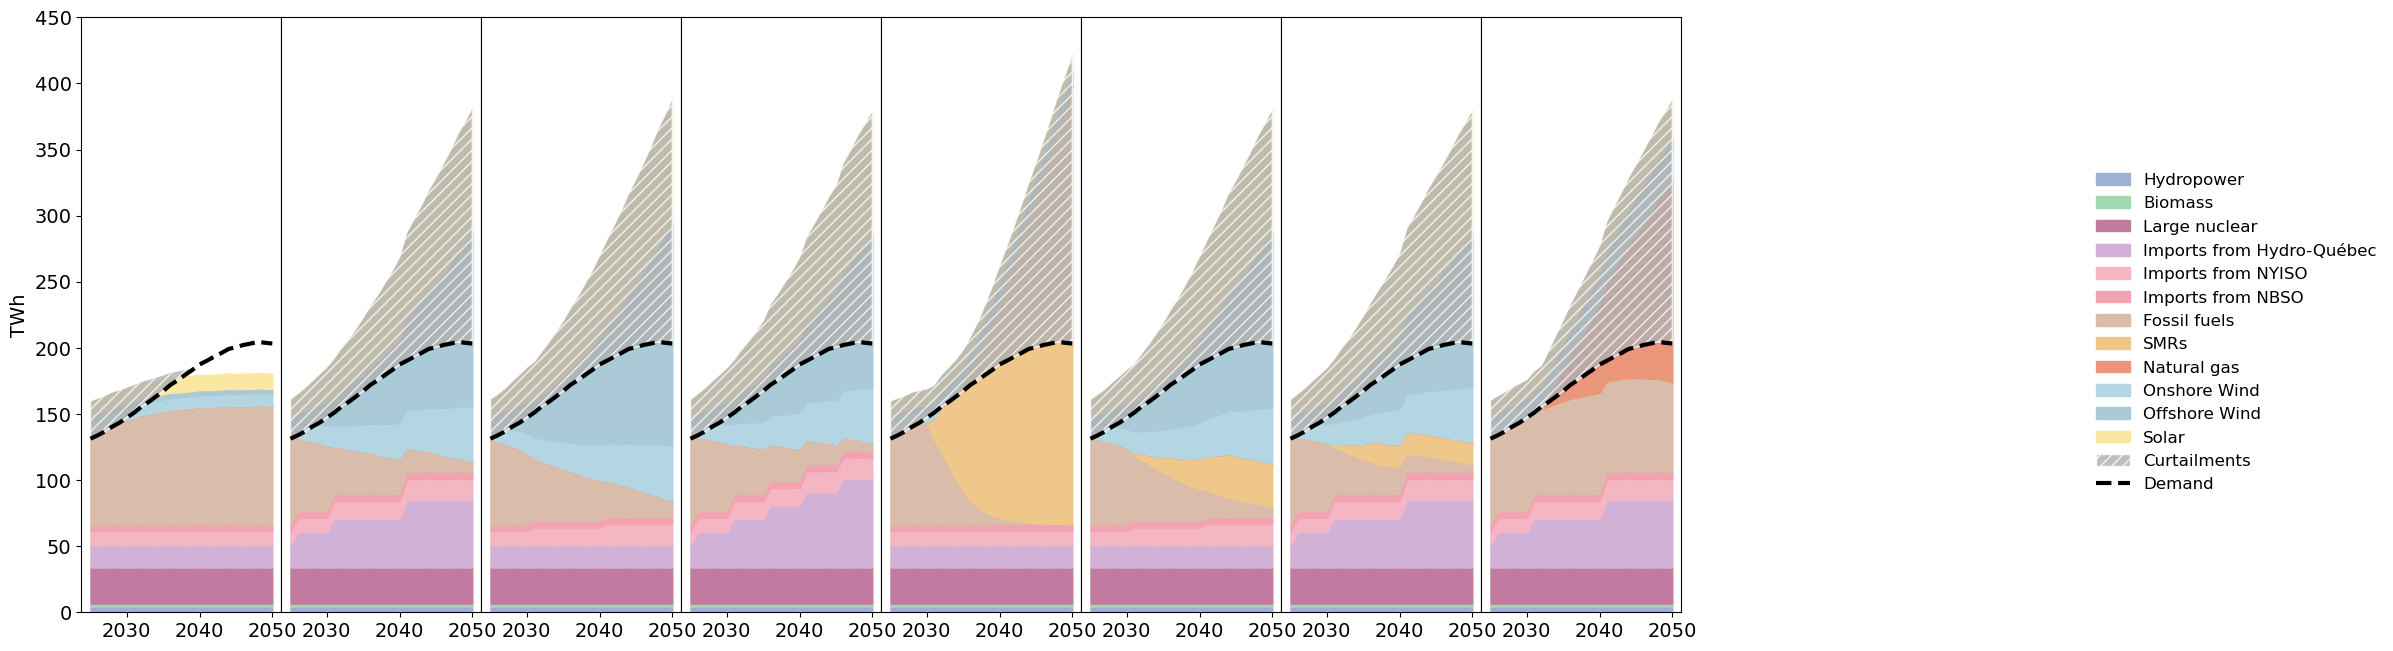

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------------------------------------------------------
# (Assume Yearly_Results is your DataFrame read from the CSV.)
# Create a combined column for Hydro-Québec imports as the sum of two columns.
Yearly_Results['Combined_Imports_HQ_TWh'] = (
    Yearly_Results['Spot_Market_Imports_HQ_TWh'] +
    Yearly_Results['Long_Term_Imports_HQ_TWh']
)

# =============================================================================
# Define legend mapping and colors (using TWh names)
# =============================================================================

legend_names = {
    'Nuclear_TWh': 'Large nuclear',
    'Hydro_TWh': 'Hydropower',
    'Biomass_TWh': 'Biomass',
    'Old_Fossil_Fuels_adj_TWh': 'Fossil fuels',
    'Combined_Imports_HQ_TWh': 'Imports from Hydro-Québec',
    'Import_NYISO_TWh': 'Imports from NYISO',
    'Import_NBSO_TWh': 'Imports from NBSO',
    'Onshore_TWh': 'Onshore Wind',
    'Offshore_TWh': 'Offshore Wind',
    'Solar_TWh': 'Solar',
    'SMR_TWh': 'SMRs',
    'New_Fossil_Fuel_TWh': 'Natural gas'
}

colors = {
    "Fossil fuels": "#D9BCA9",
    "Natural gas": "#E9967A",
    "Large nuclear": "#C27BA0",
    "SMRs": "#F0C78A",
    "Hydropower": "#9EB1D4",
    "Biomass": "#A2D9B1",
    "Imports from Hydro-Québec": "#D1B1D6",
    "Imports from NYISO": "#F4B6C2",
    "Imports from NBSO": "#F2A2B0",
    "Solar": "#FBE7A1",
    "Onshore Wind": "#B4D6E3",
    "Offshore Wind": "#A9CAD6"
}

# Define the stacking order using the friendly names.
columns_ordered = [
    'Hydropower', 'Biomass', 'Large nuclear', 'Imports from Hydro-Québec',
    'Imports from NYISO', 'Imports from NBSO', 'Fossil fuels', 
    'SMRs', 'Natural gas', 'Onshore Wind', 'Offshore Wind', 'Solar'
]

# =============================================================================
# Pivot the Yearly_Results Data for Stacked Plotting
# =============================================================================
melted = Yearly_Results.melt(
    id_vars=['Year', 'Pathway'], 
    value_vars=list(legend_names.keys()), 
    var_name='Source', 
    value_name='Generation'
)

# Map raw variable names to friendly names.
melted['Source'] = melted['Source'].map(legend_names)

# Compute the mean generation for each Year, Pathway, and Source.
mean_summary = melted.groupby(['Year', 'Pathway', 'Source']).agg({'Generation': 'mean'}).reset_index()

# =============================================================================
# Plotting Function for Each Pathway
# =============================================================================

plt.rcParams.update({'font.size': 14})
fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(20, 7), gridspec_kw={'hspace': 0.2, 'wspace': 0})

def plot_pathway(ax, data, pathway, yr_data, show_y_axis):
    # Get the sorted list of unique years.
    years = sorted(data['Year'].unique())
    bottom = np.zeros(len(years))
    
    # 1. Draw the stacked generation components (low zorder).
    for source in columns_ordered:
        subset = data[data['Source'] == source]
        subset = subset.set_index('Year').reindex(years).reset_index()
        ax.fill_between(years, bottom, bottom + subset['Generation'], 
                        label=source, color=colors[source], zorder=1)
        bottom += subset['Generation']
    
    # 2. Compute the Curtailments line.
    numeric_cols = [
        'Clean_TWh', 
        'Calibrated_Battery_discharge', 
        'Calibrated_Battery_charge', 
        'Old_Fossil_Fuels_adj_TWh', 
        'New_Fossil_Fuel_TWh', 
        'Calibrated_Total_import_net_TWh', 
        'Demand'
    ]
    grouped = yr_data.groupby('Year')[numeric_cols].mean().reset_index()
    grouped['Demand'] = grouped['Demand'] / 1e6
    grouped['Calibrated_Battery_charge'] = grouped['Calibrated_Battery_charge'] / 1e6
    grouped['Calibrated_Battery_discharge'] = grouped['Calibrated_Battery_discharge'] / 1e6
    
    grouped['Excess'] = (
        grouped['Clean_TWh'] +
        grouped['Calibrated_Battery_discharge'] +
        grouped['Old_Fossil_Fuels_adj_TWh'] +
        grouped['New_Fossil_Fuel_TWh'] +
        grouped['Calibrated_Total_import_net_TWh'] - grouped['Demand'] - grouped['Calibrated_Battery_charge']
    ).clip(lower=0)
    
    grouped['Curtailments'] = grouped['Demand'] + grouped['Excess']
    
    # 3. Draw the fill between Demand and Curtailments and then plot the lines with higher zorder.
    ax.fill_between(grouped['Year'], grouped['Demand'], grouped['Curtailments'], 
                    color='#B0B0B0', alpha=0.8, edgecolor="white", hatch="///", 
                    zorder=5, label='Curtailments')
    ax.plot(grouped['Year'], grouped['Demand'], color='black', linestyle='--', 
            linewidth=3, zorder=10, label='Demand')

    ax.set_ylim(0, 450)
    if show_y_axis:
        ax.set_ylabel('TWh', fontsize=14)
    else:
        ax.set_yticks([])

# =============================================================================
# Generate the Plot for Each Pathway
# =============================================================================
pathways = sorted(Yearly_Results["Pathway"].unique())
for i in range(8):
    data = mean_summary[mean_summary['Pathway'] == pathways[i]]
    yr_data = Yearly_Results[Yearly_Results['Pathway'] == pathways[i]]
    show_y_axis = (i == 0)
    plot_pathway(axes[i], data, pathways[i], yr_data, show_y_axis)

# =============================================================================
# Add a Unified Legend with extra distance from the plots and Save the Figure
# =============================================================================
handles, labels = axes[0].get_legend_handles_labels()
# Place the legend outside of the plot area with extra horizontal space using bbox_to_anchor.
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize=12, frameon=False)

plt.subplots_adjust(left=0.05, right=0.85, top=0.95, bottom=0.1)
plt.savefig('Generation_Pathways.svg', dpi=300, bbox_inches='tight')
plt.show()


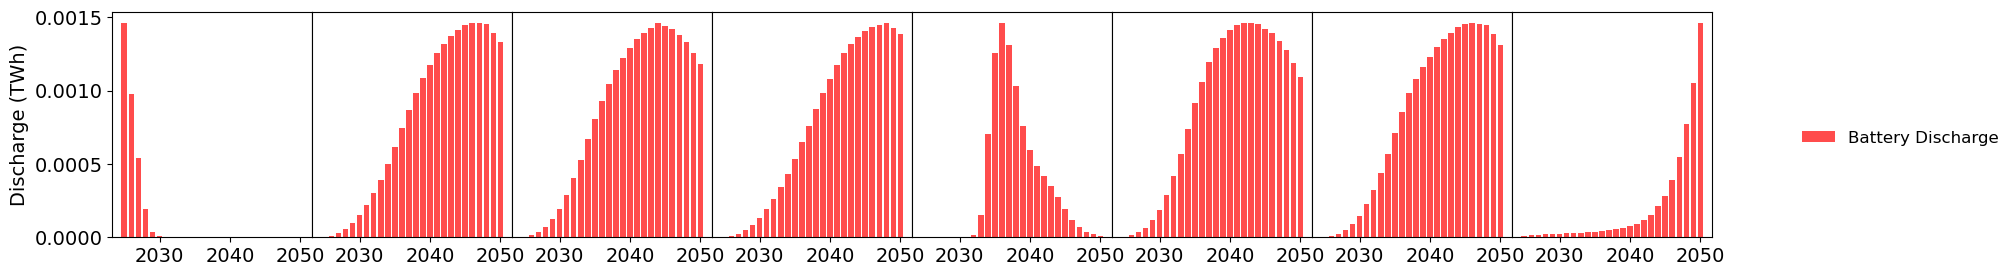

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assume Yearly_Results is already loaded from your CSV.
# For example:
# Yearly_Results = pd.read_csv("Yearly_Results.csv")

def plot_battery_discharge_bar(ax, yr_data, show_y_axis):
    # Group by Year and calculate the mean Battery_discharge (in MWh).
    # (Change .mean() to .sum() if summing is more appropriate for your data.)
    grouped = yr_data.groupby("Year")["Battery_discharge"].mean().reset_index()
    
    # Convert Battery_discharge from MWh to TWh.
    # Note: We use "Battery_discharge_TWh" consistently.
    grouped["Battery_discharge_TWh"] = grouped["Battery_discharge"] / 1e6
    
    # Create a bar chart using the grouped data.
    ax.bar(grouped["Year"], grouped["Battery_discharge_TWh"],
           color="red", alpha=0.7, label="Battery Discharge")
    
    # Set y-axis limits based on the data.
    #ax.set_ylim(0, grouped["Battery_discharge_GWh"].max() * 1.2)
    
    if show_y_axis:
        ax.set_ylabel("Discharge (TWh)", fontsize=14)
    else:
        ax.set_yticks([])
    
    #ax.set_title(f"Pathway: {yr_data['Pathway'].iloc[0]}", fontsize=12)
    #ax.set_xlabel("Year", fontsize=12)
    #ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.rcParams.update({'font.size': 14})

# Create 1×8 subplots. Adjust the number of columns if you have fewer pathways.
fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(20, 3), gridspec_kw={'wspace': 0.0})

# Get unique pathway values from your dataset.
pathways = sorted(Yearly_Results["Pathway"].unique())

for i in range(8):
    yr_data = Yearly_Results[Yearly_Results["Pathway"] == pathways[i]]
    show_y_axis = (i == 0)  # Show y-axis only on the first subplot
    plot_battery_discharge_bar(axes[i], yr_data, show_y_axis)

# Add a unified legend (using the first axis's handles/labels).
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='right', fontsize=12, frameon=False)

plt.subplots_adjust(left=0.05, right=0.85, top=0.9, bottom=0.15)
plt.savefig("Battery_Discharge.svg", dpi=300, bbox_inches="tight")
plt.show()


In [17]:
columns_ordered = ['Hydropower', 'Biomass','Large nuclear',   'Imports from Quebec',
                   'Imports from NYISO', 'Imports from NBSO','Existing fossil fuels', 'SMRs', 'New natural gas',
                   'Onshore Wind', 'Offshore Wind', 'Solar']

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Function to filter and summarize data for a given date range
def summarize_data_for_date(df, start_date, end_date):
    df['Date'] = pd.to_datetime(df['Date'])
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    df_filtered = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]
    
    hourly_summary = df_filtered.groupby(['Date', 'Hour']).agg({
        'Solar.gen_hr_MW': 'mean',
        'Onwind.gen_hr_MW': 'mean',
        'Offwind.gen_hr_MW': 'mean',
        'Nuclear.gen_hr_MW': 'mean',
        'SMR.gen_hr_MW': 'mean',
        'Hydro.gen_hr_MW': 'mean',
        'Bio.gen_hr_MW': 'mean',
        'Fossil_old.gen_hr_MW': 'mean',
        'Fossil_new.gen_hr_MW': 'mean',
        'Import.QC_hr_MW': 'mean',
        'Import.NYISO_hr_MW': 'mean',
        'Import.NB_hr_MW': 'mean',
        'Imports.total_hr_MW': 'mean',
        'Storage.status_hr_MW': 'mean',
        'Storage.charging_hours': 'max',
        'Storage.discharging_hours': 'max',
        'Demand.total_hr_MW': 'mean',
        'ExcessClean.gen_hr_MW': 'mean',
        'Total.gen_hr_MW': 'mean'
    }).reset_index()

    hourly_summary['Storage.charging_hours'] = hourly_summary['Storage.charging_hours'].astype(int)
    hourly_summary['Storage.discharging_hours'] = hourly_summary['Storage.discharging_hours'].astype(int)
    hourly_summary['Battery_Charging'] = hourly_summary['Storage.status_hr_MW'] * hourly_summary['Storage.charging_hours']
    hourly_summary['Battery_Discharging'] = hourly_summary['Storage.status_hr_MW'] * hourly_summary['Storage.discharging_hours']
    
    columns_to_convert = [
        'Solar.gen_hr_MW', 'Onwind.gen_hr_MW', 'Offwind.gen_hr_MW', 'Nuclear.gen_hr_MW',
        'SMR.gen_hr_MW', 'Hydro.gen_hr_MW', 'Bio.gen_hr_MW', 'Fossil_old.gen_hr_MW',
        'Fossil_new.gen_hr_MW', 'Import.QC_hr_MW', 'Import.NYISO_hr_MW', 'Import.NB_hr_MW',
        'Imports.total_hr_MW', 'Total.gen_hr_MW',
        'Demand.total_hr_MW', 'Battery_Charging', 'Battery_Discharging', 'ExcessClean.gen_hr_MW'
    ]
    
    for column in columns_to_convert:
        hourly_summary[column] = hourly_summary[column] / 1000.0
    
    # Combine Date and Hour into a single sequential datetime index
    hourly_summary['Datetime'] = pd.to_datetime(hourly_summary['Date']) + pd.to_timedelta(hourly_summary['Hour'], unit='h')
    return hourly_summary

# Legend names and their mapping to columns
legend_mapping = {
    'Hydro.gen_hr_MW': 'Hydropower',
    'Bio.gen_hr_MW': 'Biomass',
    'Nuclear.gen_hr_MW': 'Large nuclear',
    'Import.QC_hr_MW': 'Imports from Quebec',
    'Import.NYISO_hr_MW': 'Imports from NYISO',
    'Import.NB_hr_MW': 'Imports from NBSO',
    'Fossil_old.gen_hr_MW': 'Existing fossil fuels',
    'SMR.gen_hr_MW': 'SMRs',
    'Fossil_new.gen_hr_MW': 'New natural gas',
    'Onwind.gen_hr_MW': 'Onshore Wind',
    'Offwind.gen_hr_MW': 'Offshore Wind',
    'Solar.gen_hr_MW': 'Solar',
}

columns_ordered = list(legend_mapping.keys())

colors = {
    'Hydro.gen_hr_MW': '#9EB1D4',
    'Bio.gen_hr_MW': '#A2D9B1',
    'Nuclear.gen_hr_MW': '#C27BA0',
    'Import.QC_hr_MW': '#D1B1D6',
    'Import.NYISO_hr_MW': '#F4B6C2',
    'Import.NB_hr_MW': '#F2A2B0',
    'Fossil_old.gen_hr_MW': '#D9BCA9',
    'SMR.gen_hr_MW': '#F0C78A',
    'Fossil_new.gen_hr_MW': '#E9967A',
    'Onwind.gen_hr_MW': '#B4D6E3',
    'Offwind.gen_hr_MW': '#A9CAD6',
    'Solar.gen_hr_MW': '#FBE7A1',
}

def plot_pathway_data(pathway_data, start_date, end_date):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18, 12), gridspec_kw={'height_ratios': [3, 1]})
    main_ax, battery_ax = axes

    x = pathway_data['Datetime']
    bottom = np.zeros(len(x))

    # Filter sources with non-zero values
    active_sources = [col for col in columns_ordered if pathway_data[col].sum() > 0]

    for source in active_sources:
        main_ax.fill_between(
            x,
            bottom,
            bottom + pathway_data[source],
            label=legend_mapping[source],
            color=colors[source]
        )
        bottom += pathway_data[source]

    main_ax.plot(
        x, pathway_data['Demand.total_hr_MW'],
        linestyle='-', linewidth=3, color='black', label='Demand'
    )

    if 'ExcessClean.gen_hr_MW' in pathway_data.columns:
        main_ax.plot(
            x, pathway_data['Demand.total_hr_MW'] + pathway_data['ExcessClean.gen_hr_MW'],
            linestyle='--', linewidth=3, color='red', label='Curtailment'
        )

    battery_ax.bar(x, pathway_data['Battery_Charging'], color='green', label='Battery Charging')
    battery_ax.bar(x, pathway_data['Battery_Discharging'], color='red', label='Battery Discharging')

    main_ax.set_xlim(pd.to_datetime(start_date), pd.to_datetime(end_date) + pd.Timedelta(days=1))
    main_ax.legend(
        loc='upper left', 
        bbox_to_anchor=(-0.25, 1), 
        fontsize=10, 
        frameon=False
    )
    main_ax.set_ylabel("Generation (GW)")

    battery_ax.set_xlim(pd.to_datetime(start_date), pd.to_datetime(end_date) + pd.Timedelta(days=1))
    battery_ax.set_ylabel("Battery Status (GW)")
    battery_ax.set_xlabel("Time")

    plt.tight_layout()
    plt.show()

# Weekly plot
start_date = "2050-01-23"
end_date = "2050-01-27"

hourly_summary = summarize_data_for_date(hourly_results, start_date, end_date)
plot_pathway_data(hourly_summary, start_date, end_date)


KeyError: "Column(s) ['Bio.gen_hr_MW', 'Demand.total_hr_MW', 'ExcessClean.gen_hr_MW', 'Fossil_new.gen_hr_MW', 'Fossil_old.gen_hr_MW', 'Hydro.gen_hr_MW', 'Import.NB_hr_MW', 'Import.NYISO_hr_MW', 'Import.QC_hr_MW', 'Imports.total_hr_MW', 'Nuclear.gen_hr_MW', 'Offwind.gen_hr_MW', 'Onwind.gen_hr_MW', 'SMR.gen_hr_MW', 'Solar.gen_hr_MW', 'Storage.charging_hours', 'Storage.discharging_hours', 'Storage.status_hr_MW', 'Total.gen_hr_MW'] do not exist"

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_pathway_data(pathway_data, start_date, end_date):
    # Calculate battery difference (lag) in GWh
    pathway_data['Battery_Difference'] = pathway_data['Storage.status_hr_MW'].diff().fillna(0) / 1000

    fig, ax = plt.subplots(figsize=(12, 10))

    x = pathway_data['Datetime']
    bottom = np.zeros(len(x))

    # Filter sources with non-zero values
    active_sources = [col for col in columns_ordered if pathway_data[col].sum() > 0]

    # Stack all sources for generation
    for source in active_sources:
        ax.fill_between(
            x,
            bottom,
            bottom + pathway_data[source],
            label=legend_mapping[source],
            color=colors[source]
        )
        bottom += pathway_data[source]

    # Add battery charging (green) below the plot, starting from zero
    battery_charge = pathway_data['Battery_Difference'].where(pathway_data['Battery_Difference'] > 0, 0)
    ax.fill_between(
        x,
        0,
        -battery_charge,
        label='Battery charging',
        color='green',
        alpha=0.7
    )

    # Add battery discharging (red) on top of all generation stacks
    battery_discharge = pathway_data['Battery_Difference'].where(pathway_data['Battery_Difference'] < 0, 0)
    ax.fill_between(
        x,
        bottom,
        bottom + battery_discharge.abs(),
        label='Battery discharging',
        color='red',
        alpha=0.7
    )

    # Add demand curve
    ax.plot(
        x, pathway_data['Demand.total_hr_MW'],
        linestyle='-', linewidth=3, color='black', label='Demand'
    )
    

    pathway_data['Curtailments'] = (
        pathway_data['Imports.total_hr_MW'] +
        pathway_data['Total.gen_hr_MW'] -
        pathway_data['Demand.total_hr_MW'] - (battery_charge))
    # Set curtailments to zero if generation + imports is below demand
    pathway_data['Curtailments'] = pathway_data['Curtailments'].apply(lambda x: max(x, 0))

    # Add curtailment if available
    if 'ExcessClean.gen_hr_MW' in pathway_data.columns:
        # Plot the line for the sum
        ax.plot(
            x, 
            pathway_data['Demand.total_hr_MW'] + pathway_data['Curtailments'],
            linestyle='--', 
            linewidth=3, 
            color='grey'
        )
        
        # Add the shaded area between demand and the sum
        ax.fill_between(
            x, 
            pathway_data['Demand.total_hr_MW'], 
            pathway_data['Demand.total_hr_MW'] + pathway_data['Curtailments'],  
            color='#B0B0B0', alpha=0.8, edgecolor="white", hatch="///",
            label='Curtailment'
        )
        


    # Configure the plot
    ax.set_xlim(pd.to_datetime(start_date), pd.to_datetime(end_date) + pd.Timedelta(days=1))
    ax.legend(
        loc='upper left', 
        bbox_to_anchor=(-0.25, 1), 
        fontsize=10, 
        frameon=False
    )
    ax.set_ylabel("Generation (GWh)")
    ax.set_xlabel("Time")
    plt.tight_layout()
    plt.savefig('Sample_week_comp_B1_sim1.svg', dpi=300, bbox_inches='tight')
    plt.show()

# Weekly plot
start_date = "2050-01-23"
end_date = "2050-01-27"

start_date = "2048-11-04"
end_date = "2048-11-10"

hourly_summary = summarize_data_for_date(hourly_results, start_date, end_date)
plot_pathway_data(hourly_summary, start_date, end_date)


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_pathway_data(pathway_data, start_date, end_date):
    # Calculate battery difference (lag) in GWh
    pathway_data['Battery_Difference'] = pathway_data['Storage.status_hr_MW'].diff().fillna(0) / 1000
    
    # Extract year from start_date
    year_of_interest = pd.to_datetime(start_date).year
    max_storage_status = pathway_data[pathway_data['Datetime'].dt.year == year_of_interest]['Storage.status_hr_MW'].max()
    
    # Calculate State of Charge
    pathway_data['State_of_Charge'] = pathway_data['Storage.status_hr_MW'] * 100/ max_storage_status

    fig, ax = plt.subplots(figsize=(14, 12))

    x = pathway_data['Datetime']
    bottom = np.zeros(len(x))

    # Filter sources with non-zero values
    active_sources = [col for col in columns_ordered if pathway_data[col].sum() > 0]

    # Stack all sources for generation
    for source in active_sources:
        ax.fill_between(
            x,
            bottom,
            bottom + pathway_data[source],
            label=legend_mapping[source],
            color=colors[source]
        )
        bottom += pathway_data[source]

    # Add battery charging (green) below the plot, starting from zero
    battery_charge = pathway_data['Battery_Difference'].where(pathway_data['Battery_Difference'] > 0, 0)
    ax.fill_between(
        x,
        0,
        -battery_charge,
        label='Battery charging',
        color='green',
        alpha=0.7
    )

    # Add battery discharging (red) on top of all generation stacks
    battery_discharge = pathway_data['Battery_Difference'].where(pathway_data['Battery_Difference'] < 0, 0)
    ax.fill_between(
        x,
        bottom,
        bottom + battery_discharge.abs(),
        label='Battery discharging',
        color='red',
        alpha=0.7
    )

    # Add demand curve
    ax.plot(
        x, pathway_data['Demand.total_hr_MW'],
        linestyle='-', linewidth=3, color='black', label='Demand'
    )
    

    pathway_data['Curtailments'] = (
        pathway_data['Imports.total_hr_MW'] +
        pathway_data['Total.gen_hr_MW'] -
        pathway_data['Demand.total_hr_MW'] - (battery_charge))
    # Set curtailments to zero if generation + imports is below demand
    pathway_data['Curtailments'] = pathway_data['Curtailments'].apply(lambda x: max(x, 0))

    # Add curtailment if available
    if 'ExcessClean.gen_hr_MW' in pathway_data.columns:
        # Plot the line for the sum
        ax.plot(
            x, 
            pathway_data['Demand.total_hr_MW'] + pathway_data['Curtailments'],
            linestyle='--', 
            linewidth=3, 
            color='grey'
        )
        
        # Add the shaded area between demand and the sum
        ax.fill_between(
            x, 
            pathway_data['Demand.total_hr_MW'], 
            pathway_data['Demand.total_hr_MW'] + pathway_data['Curtailments'],  
            color='#B0B0B0', alpha=0.8, edgecolor="white", hatch="///",
            label='Curtailment'
        )
        
    # Add State of Charge bar chart on the secondary Y-axis
    ax2 = ax.twinx()
    
    # Scale SoC values to fit within the smaller range
    scaled_soc_values = pathway_data['State_of_Charge'] / 10  # Shrinks range from 0-100 to 0-20
    
    # Plot the SoC as a bar chart
    ax2.bar(
        x, scaled_soc_values,
        width=0.03,  # Adjust bar width for aesthetics
        color='none', edgecolor='#A8DADC', label='State of charge', hatch='///'
    )
    
    # Set secondary Y-axis label and limits
    ax2.set_ylim(0, 100)  # Smaller Y-axis range
    ax2.set_yticks([])  # Remove ticks
    ax2.set_yticklabels([])  # Remove tick labels
    ax2.legend(
        loc='lower left', 
        bbox_to_anchor=(-0.25, 1), 
        fontsize=10, 
        frameon=False
    )
    #ax2.spines['right'].set_color('#A8DADC')  # Set the color of the axis spine

    # Configure the plot
    ax.set_xlim(pd.to_datetime(start_date), pd.to_datetime(end_date) + pd.Timedelta(days=1))
    ax.legend(
        loc='upper left', 
        bbox_to_anchor=(-0.25, 1), 
        fontsize=10, 
        frameon=False
    )
    #ax.set_ylabel("Generation (GWh)")
    #ax.set_xlabel("Time")
    plt.tight_layout()
    plt.savefig('Sample_week_comp_B1_sim831.svg', dpi=300, bbox_inches='tight')
    plt.show()

# Weekly plot
start_date = "2050-01-23"
end_date = "2050-01-27"

#start_date = "2048-11-04"
#end_date = "2048-11-10"

filtered_results = hourly_results[hourly_results['Pathway'] == 'B1']

hourly_summary = summarize_data_for_date(filtered_results, start_date, end_date)
plot_pathway_data(hourly_summary, start_date, end_date)


KeyError: "Column(s) ['Bio.gen_hr_MW', 'Demand.total_hr_MW', 'ExcessClean.gen_hr_MW', 'Fossil_new.gen_hr_MW', 'Fossil_old.gen_hr_MW', 'Hydro.gen_hr_MW', 'Import.NB_hr_MW', 'Import.NYISO_hr_MW', 'Import.QC_hr_MW', 'Imports.total_hr_MW', 'Nuclear.gen_hr_MW', 'Offwind.gen_hr_MW', 'Onwind.gen_hr_MW', 'SMR.gen_hr_MW', 'Solar.gen_hr_MW', 'Storage.charging_hours', 'Storage.discharging_hours', 'Storage.status_hr_MW', 'Total.gen_hr_MW'] do not exist"

In [7]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# 1) Human‐readable labels
legend_mapping = {
    "Solar":               "Solar",
    "Offshore Wind":       "Offshore wind",
    "Onshore Wind":        "Onshore wind",
    "Imports NBSO":        "Imports from NBSO",
    "Imports NYISO":       "Imports from NYISO",
    "Imports QC":          "Imports from Hydro-Québec",
    "Biomass":             "Biomass",
    "Hydropower":          "Hydropower",
    "Nuclear":             "Large nuclear",
    "Old fossil":          "Fossil fuels (incl. existing/retired \ncoal, oil, natural gas and wood)",
    "Curtailment":         "Curtailment",
    "Demand":              "Demand",
    "Battery discharging": "Battery discharging",
    "Battery charging":    "Battery charging",
}

# 2) Exact colours
colors = {
    "Solar":               "#FBE7A1",
    "Offshore Wind":       "#A9CAD6",
    "Onshore Wind":        "#B4D6E3",
    "Imports NBSO":        "#F2A2B0",
    "Imports NYISO":       "#F4B6C2",
    "Imports QC":          "#D1B1D6",
    "Biomass":             "#A2D9B1",
    "Hydropower":          "#9EB1D4",
    "Nuclear":             "#C27BA0",
    "Old fossil":          "#D9BCA9",
    "Curtailment":         "#B0B0B0",
    "Demand":              "black",
    "Battery discharging": "#F44336",
    "Battery charging":    "#4CAF50",
}

# 3) Final vertical order (top→bottom), fossil last
columns_ordered = [
    "Solar",
    "Offshore Wind",
    "Onshore Wind",
    "Imports NBSO",
    "Imports NYISO",
    "Imports QC",
    "Biomass",
    "Hydropower",
    "Nuclear",
    "Old fossil",
    "Curtailment",
    "Demand",
    "Battery discharging",
    "Battery charging",
]

# 4) Build handles
handles = []
for key in columns_ordered:
    if key == "Demand":
        handles.append(Line2D([0], [0],
                              color=colors[key], lw=2,
                              label=legend_mapping[key]))
    elif key == "Curtailment":
        handles.append(Patch(facecolor=colors[key],
                             edgecolor="white",
                             hatch="///",
                             label=legend_mapping[key]))
    else:
        handles.append(Patch(facecolor=colors[key],
                             edgecolor="none",
                             label=legend_mapping[key]))

# 5) Draw legend-only figure and save as SVG
fig, ax = plt.subplots(figsize=(3, 8))
ax.legend(handles=handles,
          loc="center",
          ncol=1,
          frameon=False,
          handlelength=2,
          labelspacing=0.8)
ax.axis("off")
fig.savefig("legend.svg", format="svg", bbox_inches="tight")
plt.close(fig)


# Updated 18 May 2025 

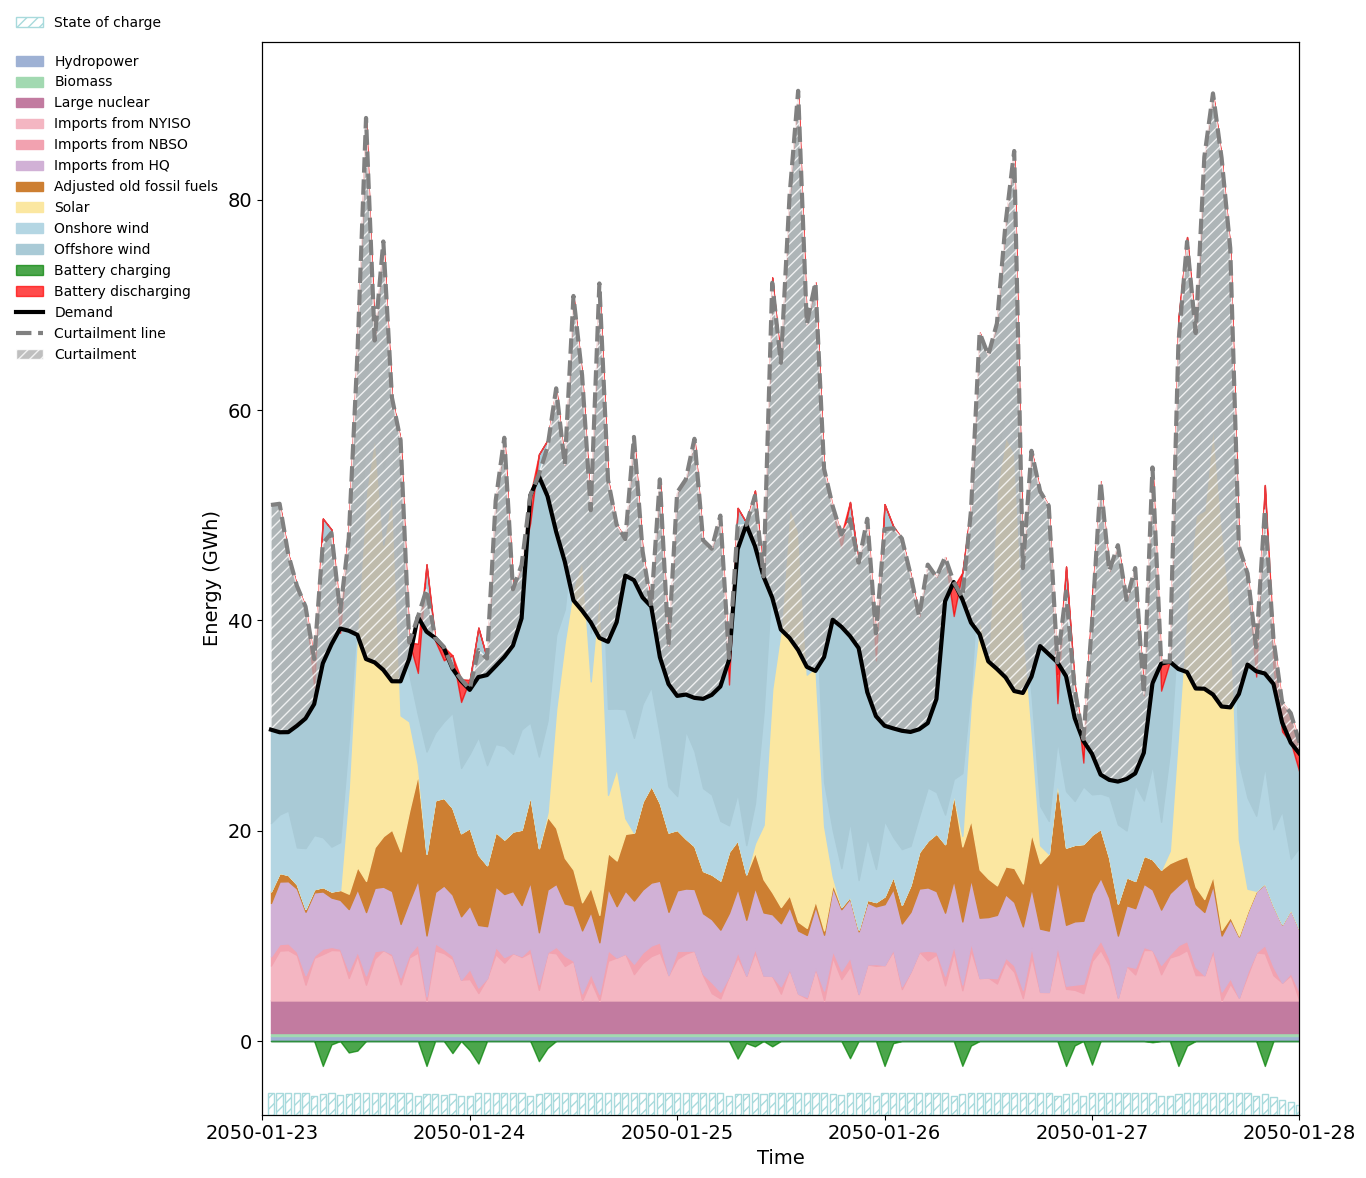

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def summarize_data_for_date(df, start_date, end_date):
    df = df.copy()

    # 1) Override with calibrated values if available
    calibration_map = {
        'Storage_status':               'Calibrated_Storage_status',
        'Spot_Market_Imports_HQ_MWh':   'Calibrated_Spot_Market_Imports_HQ_MWh',
        'Long_Term_Imports_HQ_MWh':     'Calibrated_Long_Term_Imports_HQ_MWh',
        'Import_NYISO_MWh':             'Calibrated_Import_NYISO_MWh',
        'Import_NBSO_MWh':              'Calibrated_Import_NBSO_MWh',
        'Curtailments_MWh':             'Calibrated_Curtailments_MWh'
    }
    for regular_col, calib_col in calibration_map.items():
        if calib_col in df.columns:
            df[regular_col] = df[calib_col]

    # 2) Filter by date
    df['Date'] = pd.to_datetime(df['Date'])
    start = pd.to_datetime(start_date)
    end   = pd.to_datetime(end_date)
    df_filt = df[(df['Date'] >= start) & (df['Date'] <= end)]

    # 3) Columns to average hourly (now including Old_Fossil_Fuels_adj_MWh)
    cols_to_mean = [
        'Solar_MWh', 'Onshore_MWh', 'Offshore_MWh',
        'Nuclear_MWh','Hydro_MWh', 'Biomass_MWh',
        'SMR_MWh', 'New_Fossil_Fuel_MWh',
        'Spot_Market_Imports_HQ_MWh','Long_Term_Imports_HQ_MWh',
        'Import_NYISO_MWh','Import_NBSO_MWh',
        'Old_Fossil_Fuels_adj_MWh',
        'Curtailments_MWh',
        'Storage_status',
        'Demand'
    ]
    agg_dict = {c: 'mean' for c in cols_to_mean if c in df_filt.columns}

    hourly = (
        df_filt
          .groupby(['Date','Hour'])
          .agg(agg_dict)
          .reset_index()
    )

    # 4) Recompute HQ imports from (now‐calibrated) spot + long‐term
    hourly['HQ_Imports_MWh'] = (
        hourly['Spot_Market_Imports_HQ_MWh']
      + hourly['Long_Term_Imports_HQ_MWh']
    )

    # 5) Build a full datetime for plotting
    hourly['Datetime'] = (
        pd.to_datetime(hourly['Date'])
      + pd.to_timedelta(hourly['Hour'], unit='h')
    )

    return hourly

# --- stacking & plotting setup ---

legend_mapping = {
    'Hydro_MWh':               'Hydropower',
    'Biomass_MWh':             'Biomass',
    'Nuclear_MWh':             'Large nuclear',
    'Import_NYISO_MWh':        'Imports from NYISO',
    'Import_NBSO_MWh':         'Imports from NBSO',
    'HQ_Imports_MWh':          'Imports from HQ',
    'Old_Fossil_Fuels_adj_MWh':'Adjusted old fossil fuels',
    'Solar_MWh':               'Solar',
    'Onshore_MWh':             'Onshore wind',
    'Offshore_MWh':            'Offshore wind',
    'SMR_MWh':                 'SMRs',
    'New_Fossil_Fuel_MWh':     'New natural gas',
}

columns_ordered = list(legend_mapping.keys())

colors = {
    'Hydro_MWh':               '#9EB1D4',
    'Biomass_MWh':             '#A2D9B1',
    'Nuclear_MWh':             '#C27BA0',
    'Import_NYISO_MWh':        '#F4B6C2',
    'Import_NBSO_MWh':         '#F2A2B0',
    'HQ_Imports_MWh':          '#D1B1D6',
    'Old_Fossil_Fuels_adj_MWh':'#CD7F32',
    'Solar_MWh':               '#FBE7A1',
    'Onshore_MWh':             '#B4D6E3',
    'Offshore_MWh':            '#A9CAD6',
    'SMR_MWh':                 '#F0C78A',
    'New_Fossil_Fuel_MWh':     '#E9967A',
}

def plot_pathway_data(p, start_date, end_date):
    df = p.copy()

    # battery delta (MWh)
    df['Battery_Diff_MWh'] = df['Storage_status'].diff().fillna(0)

    # state of charge % (year‐max)
    year0 = pd.to_datetime(start_date).year
    max_soc = df.loc[df['Datetime'].dt.year == year0, 'Storage_status'].max()
    df['State_of_Charge'] = df['Storage_status'] * 100 / max_soc

    fig, ax = plt.subplots(figsize=(14,12))
    x = df['Datetime']
    bottom = np.zeros(len(x))

    # stack gen & imports (→GWh)
    for col in columns_ordered:
        if col not in df.columns or df[col].sum() == 0:
            continue
        vals_gwh = df[col] / 1000.0
        ax.fill_between(
            x, bottom, bottom + vals_gwh,
            label=legend_mapping[col],
            color=colors.get(col, 'grey')
        )
        bottom += vals_gwh

    # battery charging/discharging (GWh)
    bc = df['Battery_Diff_MWh'].clip(lower=0) / 1000.0
    bd = df['Battery_Diff_MWh'].clip(upper=0).abs() / 1000.0
    ax.fill_between(x, 0, -bc,    label='Battery charging',   color='green', alpha=0.7)
    ax.fill_between(x, bottom, bottom + bd, label='Battery discharging', color='red',   alpha=0.7)

    # demand & curtailment lines
    demand_gwh = df['Demand'] / 1000.0
    curt_gwh   = df['Curtailments_MWh'] / 1000.0
    ax.plot( x, demand_gwh,           '-', linewidth=3, color='black', label='Demand')
    ax.plot( x, demand_gwh+curt_gwh,  '--', linewidth=3, color='grey',  label='Curtailment line')
    ax.fill_between(x, demand_gwh, demand_gwh+curt_gwh,
                    color='#B0B0B0', alpha=0.8, edgecolor='white', hatch='///',
                    label='Curtailment')

    # state-of-charge bar on secondary axis
    ax2 = ax.twinx()
    soc_scaled = df['State_of_Charge'] / 50
    ax2.bar(x, soc_scaled, width=0.03, color='none',
            edgecolor='#A8DADC', hatch='///', label='State of charge')
    ax2.set_ylim(0,100)
    ax2.set_yticks([]); ax2.set_yticklabels([])
    ax2.legend(loc='lower left', bbox_to_anchor=(-0.25,1), fontsize=10, frameon=False)

    # finalize
    ax.set_xlim(pd.to_datetime(start_date), pd.to_datetime(end_date) + pd.Timedelta(days=1))
    ax.set_xlabel('Time')
    ax.set_ylabel('Energy (GWh)')
    ax.legend(loc='upper left', bbox_to_anchor=(-0.25,1), fontsize=10, frameon=False)
    plt.tight_layout()
    plt.savefig('Sample_week_comp_B1_sim831.svg', dpi=300, bbox_inches='tight')
    plt.show()

# Usage example
filtered = hourly_results[hourly_results['Pathway']=='B1']
summary = summarize_data_for_date(filtered, "2050-01-23", "2050-01-27")
plot_pathway_data(summary, "2050-01-23", "2050-01-27")


In [25]:
summary

,Date,Hour,Solar_MW,Onshore_Wind_MW,Offshore_Wind_MW,Nuclear_MW,SMR_MW,Hydropower_MW,Biomass_MW,New_NG_MW,...,Imports_NBSO_MW,Spot_Market_Imports_HQ_MW,Long_Term_Imports_HQ_MW,Storage_status,Battery_charge,Battery_discharge,Demand,Total_import_MW,Total_gen_MW,Datetime
0,2050-01-23,1,73308.0,15278.0,33617.0,3350.0,0.0,900.0,400.0,0.0,...,1050.0,2125.0,4100.0,16109.306622,2370.805857,0.000000,29612.5,18300.0,126853.0,2050-01-23 01:00:00
1,2050-01-23,2,73308.0,15278.0,33617.0,3350.0,0.0,900.0,400.0,0.0,...,1050.0,2125.0,4100.0,18480.112479,2370.805857,0.000000,29365.0,18300.0,126853.0,2050-01-23 02:00:00
2,2050-01-23,3,73308.0,15278.0,33617.0,3350.0,0.0,900.0,400.0,0.0,...,1050.0,2125.0,4100.0,20572.000000,2091.887521,0.000000,29375.0,18300.0,126853.0,2050-01-23 03:00:00
3,2050-01-23,4,73308.0,15278.0,33617.0,3350.0,0.0,900.0,400.0,0.0,...,1050.0,2125.0,4100.0,20572.000000,0.000000,0.000000,29977.5,18300.0,126853.0,2050-01-23 04:00:00
4,2050-01-23,5,73308.0,15278.0,33617.0,3350.0,0.0,900.0,400.0,0.0,...,1050.0,2125.0,4100.0,20572.000000,0.000000,0.000000,30677.5,18300.0,126853.0,2050-01-23 05:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,2050-01-27,20,73308.0,15278.0,33617.0,3350.0,0.0,900.0,400.0,0.0,...,1050.0,2125.0,4100.0,20153.622496,2370.805857,0.000000,34952.5,18300.0,126853.0,2050-01-27 20:00:00
116,2050-01-27,21,73308.0,15278.0,33617.0,3350.0,0.0,900.0,400.0,0.0,...,1050.0,2125.0,4100.0,17364.439134,0.000000,2789.183361,33960.0,18300.0,126853.0,2050-01-27 21:00:00
117,2050-01-27,22,73308.0,15278.0,33617.0,3350.0,0.0,900.0,400.0,0.0,...,1050.0,2125.0,4100.0,14575.255773,0.000000,2789.183361,30310.0,18300.0,126853.0,2050-01-27 22:00:00
118,2050-01-27,23,73308.0,15278.0,33617.0,3350.0,0.0,900.0,400.0,0.0,...,1050.0,2125.0,4100.0,11786.072412,0.000000,2789.183361,28367.5,18300.0,126853.0,2050-01-27 23:00:00
